In [1]:
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import numpy as np 
import pandas as pd
import seaborn as sns; sns.set()
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, auc

In [2]:
testfile = 'Bladder Project pCR Prediction Data (Updated 030222)_noipc.txt'
df=pd.read_csv(testfile,sep='\t',index_col=0)
display(df)

,pCR,Age,Sex,Race,Urothelial,Smoking,NAC,MIBC,Incidental PC,utDNA,TF99
ID,,,,,,,,,,,
WBC1050,1,63,2,1,1,1,1,1,0,0.0,2.500
WBC1058,0,78,1,1,1,0,0,1,0,5.9,2.400
WBC1062,0,77,1,1,0,1,1,1,0,2.4,1.600
WBC1063,1,67,1,1,1,0,1,1,0,0.0,1.700
WBC1064,1,60,1,1,1,1,1,1,0,0.0,0.000
WBC1069,0,61,1,1,1,1,0,1,0,11.6,12.900
WBC1071,0,68,1,1,1,0,0,1,0,10.1,0.000
WBC1076,0,75,1,1,1,1,0,1,0,3.8,4.200
WBC1083,0,66,1,1,1,1,1,1,0,5.6,7.800


In [3]:
def perform_cv(operation, cols):
    df_test = df.copy()
    df_test['Operation'] = operation
    df_test = df_test[cols]

    # create loocv procedure
    cv = LeaveOneOut()
    X=df_test.drop(['pCR'],axis=1).to_numpy()
    y=df_test["pCR"].copy().to_numpy()

    # enumerate splits
    y_true, y_pred, y_proba = list(), list(), list()

    for train_ix, test_ix in cv.split(X):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        # fit model
        model = RandomForestClassifier(n_estimators=2000, random_state=1)
        model.fit(X_train, y_train)
        
        # find the best threshold
        pred_train = model.predict_proba(X_train)[:,1]
        
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_train)
        sens_train_arr = tpr_train
        spec_train_arr = 1 - fpr_train
        gmeans_train = np.sqrt(sens_train_arr * spec_train_arr)
        ix_train = np.argmax(gmeans_train)
        thresh = thresholds_train[ix_train]

        # evaluate model
        yprob = model.predict_proba(X_test)[:,1]
        yhat = list((yprob >= thresh).astype(int))

        y_proba.append(yprob[0])
        y_true.append(y_test[0])
        y_pred.append(yhat[0])
    return y_proba, y_true, y_pred

In [4]:
cols = ['pCR', 'Age', 'Sex', 'Race', 'Smoking', 'Urothelial', 'NAC', 'MIBC', 'Operation']
y_proba, y_true, y_pred = perform_cv(np.power((np.array(df['utDNA']) + 1) * (np.array(df['TF99']) + 1), 0.5), cols)

In [5]:
# calculate accuracy
acc = accuracy_score(y_true, y_pred)
print('Accuracy: %.3f' % acc)

Accuracy: 0.737


In [6]:
cm1 = confusion_matrix(y_true, y_pred)
spec_pred = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sens_pred = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Sensitivity =', sens_pred)
print('Specificity =', spec_pred)

Sensitivity = 0.5384615384615384
Specificity = 0.9032258064516129


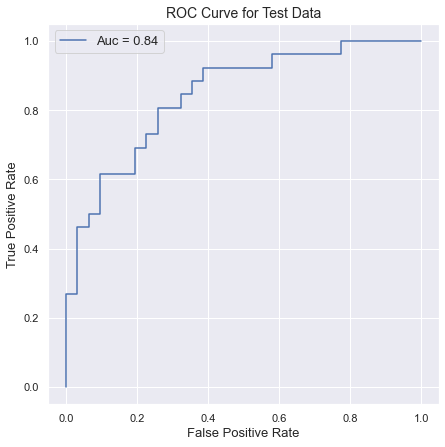

In [7]:
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
auc_test = metrics.roc_auc_score(y_true, y_proba)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(fpr, tpr, label='Auc = ' + str(np.around(auc_test, decimals=2)))
ax.set_xlabel('False Positive Rate', fontsize=13)
ax.set_ylabel('True Positive Rate', fontsize=13)
ax.set_title('ROC Curve for Test Data', fontsize=14)
plt.legend(fontsize=13)